# FLOW_API Demonstration

## FLOW project meeting

### Leuven, 10-11 Sep 2024

In [1]:
%matplotlib inline
import os
import xarray as xr
import matplotlib.pyplot as plt
from ncplot import view

from windIO.utils.yml_utils import validate_yaml
from windIO.utils import plant_schemas_path

from flow_api import run_foxes, run_pywake #, run_wayve, run_code_saturne

## Currently available example cases

In [2]:
!(cd ../examples/cases && tree -L 1)

.
├── KUL_LES
├── open_source_scada
├── windio_4turbines
├── windio_4turbines_2flowcases
├── windio_4turbines_ABL
├── windio_4turbines_ABL_stable
└── windio_4turbines_profiles_stable

8 directories, 0 files


## Example 1: Four turbines in a row, homogeneous inflow timeseries

This case is called "windio_4turbines". The input data file structure looks like this:

In [3]:
!(cd ../examples/cases/windio_4turbines && tree)

.
├── plant_energy_resource
│   ├── FLOW_toy_study_energy_resource.yaml
│   └── Stochastic_atHubHeight.nc
├── plant_energy_site
│   └── FLOW_toy_study_energy_site.yaml
├── plant_energy_turbine
│   └── DTU_10MW_turbine.yaml
├── plant_wind_farm
│   └── FLOW_toy_study_wind_farm.yaml
└── wind_energy_system
    ├── analysis.yaml
    ├── system.yaml
    └── system_no_field.yaml

6 directories, 8 files


The main file of this case is called "FLOW_toy_study_wind_energy_system.yaml". It follows the windio schema. Notice how other files are referenced via the `!include` command:

In [4]:
!cat ../examples/cases/windio_4turbines/wind_energy_system/system.yaml

name: FLOW UQ vnv study on toy problem, 4 WT Wind Farm
site: !include ../plant_energy_site/FLOW_toy_study_energy_site.yaml
wind_farm: !include ../plant_wind_farm/FLOW_toy_study_wind_farm.yaml
attributes:
  flow_model:
    name: foxes
  analysis: !include analysis.yaml

  outputs:
    output_folder: "results"
    turbine_outputs:
        turbine_nc_filename: 'turbine_data.nc' # dimension = states, turbine
        output_variables: ['power', 'rotor_effective_velocity'] #'frequency'
    #
    flow_field:
      report: True
      flow_nc_filename: flow_field.nc
      cases_run:
        all_occurences: True
      output_variables: ['wind_speed', 'wind_direction']
      z_planes:
        z_sampling: "hub_height"
        xy_sampling: "default"
    #
    statistics:
      stats_filename: None
      AEP: False
      AEP_per_turbine: False
      power_percentiles:
        report: False
        percentiles: None


This is the "analysis" input file:

In [5]:
!cat ../examples/cases/windio_4turbines/wind_energy_system/analysis.yaml

#wayve
layers_description:
  farm_layer_height: 150
  number_of_layers: 10
APM_additional_terms:
  term_list: None
wake_tool: "foxes"

#pywake and foxes
wind_deficit_model:
  name: Bastankhah2014
  wake_expansion_coefficient: # k = ka*ti + kb
    k_a: 0.0
    k_b: 0.04
    free_stream_ti: false
  ceps: 0.2
  use_effective_ws: true
axial_induction_model: Madsen
deflection_model:
  name: None
turbulence_model:
  name: CrespoHernandez
superposition_model:
  ws_superposition: Linear
  ti_superposition: Quadratic
rotor_averaging:
  grid: grid
  n_x_grid_points: 4
  n_y_grid_points: 4
  background_averaging: center
  wake_averaging: centre
  wind_speed_exponent_for_power: 3
  wind_speed_exponent_for_ct: 2
blockage_model:
  name: None

#code_saturne
run_type: "simulate" #"postprocess"
#
cases_run:
  all_occurences: True
#
HPC_config:
  run_node_number: 1
  run_ntasks_per_node: 48
  run_wall_time_hours: 6
  run_partition: ""
  #
  mesh_node_number: 1
  mesh_ntasks_per_node: 48
  mesh_wall_time

We can validate the input with windIO's `validate` function:

In [6]:
input_yaml = "../examples/cases/windio_4turbines/wind_energy_system/system.yaml"
validate_yaml(input_yaml, plant_schemas_path + 'wind_energy_system.yaml')

Validation succeeded


The `flow_model` under `attributes` states `foxes`, which means that a call of the main `flow_api` would ask `foxes` to compute results. However, this choice can be overruled by specified functions/commands.

**Provided python functions:**
- *run_api(input_yaml)*: Run the case with the flow model specified in the yaml file
- *run_foxes(input_yaml)*: Run the case with `foxes`
- *run_pywake(input_yaml)*: Run the case with `PyWake`
- *run_wayve(input_yaml)*: Run the case with `WAYVE`
- *run_code_saturne(input_yaml)*: Run the case with `code_saturne`

**Provided command-line tools:**
- *flow_api input_yaml*: Run the case with the flow model specified in the yaml file
- *flow_api_foxes input_yaml)*: Run the case with `foxes`
- *flow_api_pywake input_yaml)*: Run the case with `PyWake`
- *flow_api_wayve input_yaml)*: Run the case with `WAYVE`
- *flow_api_code_saturne input_yaml)*: Run the case with `code_saturne`

For example, we can run the main API call like as follows (Note that the "!" is only needed because we are in a notebook here, not a terminal):

In [7]:
!flow_api ../examples/cases/windio_4turbines/wind_energy_system/system.yaml

Validation succeeded
Reading windio file ../examples/cases/windio_4turbines/wind_energy_system/system.yaml
Ignoring 'z0', since no reference_height found. No ABL profile activated.
Running farm_calc
Selecting default engine 'MultiprocessEngine(chunk_size_states=None, chunk_size_points=None)'
Calculating 1000 states for 4 turbines
Computing 16 chunks using 16 processes
100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 212.05it/s]
Running output: StateTurbineTable
Writing file results/turbine_data.nc
Running output: SliceData
Calculating data at 10000 points for 1000 states
Computing 16 chunks using 16 processes
100%|███████████████████████████████████████████| 16/16 [00:04<00:00,  3.50it/s]
Writing file results/flow_field.nc


Notice that the outputs that were defined in the `yaml` above triggered the writing of two output files:

In [8]:
!tree results

results
├── flow_field.nc
└── turbine_data.nc

1 directory, 2 files


In [9]:
view("results/flow_field.nc", vars= "wind_speed")

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead


:DynamicMap   [state]
   :Image   [x,y]   (wind_speed)

In [10]:
view("results/turbine_data.nc", vars= "power")

:QuadMesh   [time,turbine]   (power)

## Comparison of foxes and PyWake

Let's re-run `foxes`, but now a version that does not export the flow field, and now using the Python function:

In [11]:
input_yaml = "../examples/cases/windio_4turbines/wind_energy_system/system_no_field.yaml"
validate_yaml(input_yaml, plant_schemas_path + 'wind_energy_system.yaml')

Validation succeeded


In [12]:
!rm -rf results
run_foxes(input_yaml)

Reading windio file ../examples/cases/windio_4turbines/wind_energy_system/system_no_field.yaml
Ignoring 'z0', since no reference_height found. No ABL profile activated.
Running farm_calc
Selecting default engine 'MultiprocessEngine(chunk_size_states=None, chunk_size_points=None)'
Calculating 1000 states for 4 turbines
Computing 16 chunks using 16 processes


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.51it/s]

Running output: StateTurbineTable
Writing file results/turbine_data.nc


In [13]:
foxes_dat = xr.load_dataset('./results/turbine_data.nc')
foxes_dat 

<xarray.Dataset> Size: 72kB
Dimensions:                   (time: 1000, turbine: 4)
Coordinates:
  * time                      (time) float64 8kB 0.0 1.0 2.0 ... 998.0 999.0
  * turbine                   (turbine) int64 32B 0 1 2 3
Data variables:
    power                     (time, turbine) float64 32kB 7.056e+06 ... 3.94...
    rotor_effective_velocity  (time, turbine) float64 32kB 10.09 8.287 ... 8.295

We now run `PyWake` on the same input, by using the `run_pywake` function. It writes to a folder called `output`:

In [14]:
!rm -rf output && mkdir output
run_pywake(input_yaml)

(1000,) ()
aep is  <xarray.DataArray 'AEP [GWh]' ()> Size: 8B
np.float64(158.78097755793266) GWh
<xarray.SimulationResult> Size: 176kB
Dimensions:      (wt: 4, time: 1000)
Coordinates:
  * time         (time) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * wt           (wt) int64 32B 0 1 2 3
    wd           (time) float64 8kB 271.8 266.2 268.7 ... 276.0 266.8 267.1
    ws           (time) float64 8kB 10.09 10.23 8.798 ... 9.704 9.613 10.36
    type         (wt) float64 32B 0.0 0.0 0.0 0.0
Data variables: (12/14)
    WS_eff       (wt, time) float64 32kB 10.09 10.23 8.798 ... 8.826 7.78 8.291
    TI_eff       (wt, time) float64 32kB 2.619 1.537 1.651 ... 4.891 3.751 4.124
    Power        (wt, time) float64 32kB 7.056e+06 7.378e+06 ... 3.939e+06
    CT           (wt, time) float64 32kB 0.814 0.814 0.814 ... 0.8237 0.814
    yaw          int64 8B 0
    tilt         int64 8B 0
    ...           ...
    y            (wt) int64 32B 0 0 0 0
    WD           (time) float64 8kB 271

<xarray.DataArray 'AEP [GWh]' ()> Size: 8B
np.float64(158.78097755793266)

In [15]:
pywake_dat = xr.load_dataset('output/PowerTable.nc')
pywake_dat

<xarray.Dataset> Size: 88kB
Dimensions:               (turbine: 4, time: 1000)
Coordinates:
  * time                  (time) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
  * turbine               (turbine) int64 32B 0 1 2 3
    wd                    (time) float64 8kB 271.8 266.2 268.7 ... 266.8 267.1
    ws                    (time) float64 8kB 10.09 10.23 8.798 ... 9.613 10.36
    type                  (turbine) float64 32B 0.0 0.0 0.0 0.0
Data variables:
    power                 (turbine, time) float64 32kB 7.056e+06 ... 3.939e+06
    effective_wind_speed  (turbine, time) float64 32kB 10.09 10.23 ... 8.291

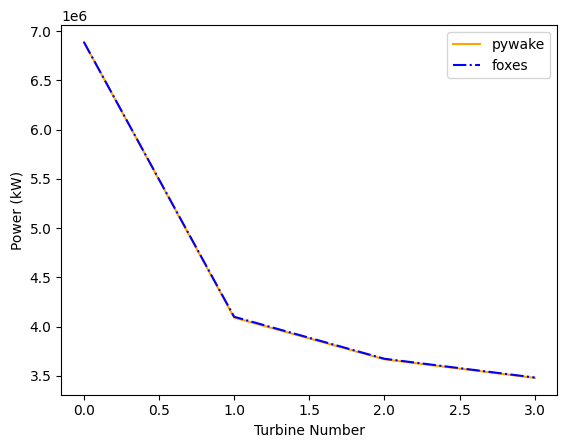

In [17]:
plt.plot(pywake_dat.turbine, pywake_dat.power.mean('time'),c='orange', label="pywake")
plt.plot(foxes_dat.turbine, foxes_dat.power.mean('time'), ls='-.',c='blue', label="foxes")
plt.xlabel('Turbine Number')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

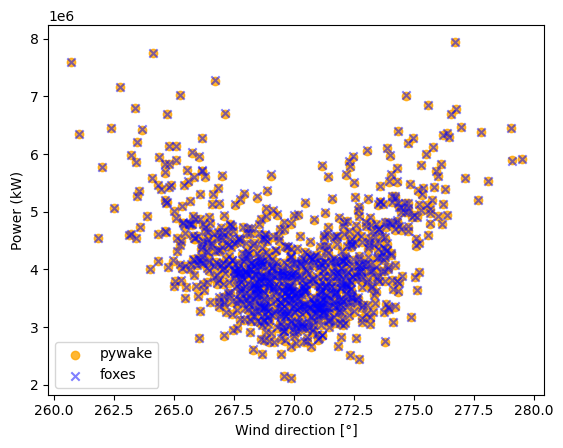

In [18]:
plt.scatter(pywake_dat.wd, pywake_dat.sel(turbine=1).power, c='orange', marker='o',alpha=0.8, label="pywake")
plt.scatter(pywake_dat.wd, foxes_dat.sel(turbine=1).power, c='blue', marker='x',alpha=0.5, label="foxes")
plt.xlabel('Wind direction [°]')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()